# Read Before

- https://www.kaggle.com/code/raddar/icr-competition-analysis-and-findings/notebook
- https://www.tensorflow.org/guide/core/logistic_regression_core
- https://www.kaggle.com/code/muelsamu/simple-tabpfn-approach-for-score-of-15-in-1-min/notebook

Plan:
- [x] Feature Engineering (1 day)
- [x] CV and Model Selection (1 day)
- [x] Validation (1 day)
- [x] Review
- [x] Make Artefacts -> Made Utility script for WoE
- [x] Solve Error With Solution -> Made If new catgory then choose worst WoEs (Can make two splits woth worst and other value )
- [x] Add TabPFN (Added Private Sample with package files) and No CV TabPFN preds
- [x] Added Weighted Submition with respect to Competion Metric Mean
- [ ] Found that some variables are constant as they represent some features for categroical column which takes only two values, so makes sense to drop them in order not overtrain. I will make split -> make two versions of model which is run if Group A (on all data), which is Group B ( which finetuned after )
- [x] Refactor More Accurately train RF part & Make Dev branch for Git
- [ ] Solve problem with accuracy
- [x] Experiment with GadientClassifier and Parameters ( Tried GadientClassifier / Added Better displayed TOC )

## Install TabPFN offline

In [1]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr

!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff

!cp /kaggle/input/pip-packages-icr/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pip-packages-icr
Processing /kaggle/input/pip-packages-icr/tabpfn-0.1.9-py3-none-any.whl


# Import Utils

In [2]:
from woe_utils import WOENumericalComplex

# Import Standard Libs

In [3]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from keras import metrics # accuracy
from keras import backend as K

import keras_tuner as kt

import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold, KFold

from tabpfn import TabPFNClassifier

import warnings
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 500)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load the Dataset

In [4]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv', index_col='Id')
dataset_df.columns = dataset_df.columns.str.rstrip()
print("Full train dataset shape is {}".format(dataset_df.shape))

dataset_test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv', index_col='Id')
dataset_test_df.columns = dataset_test_df.columns.str.rstrip()
print("Full test dataset shape is {}".format(dataset_test_df.shape))

Full train dataset shape is (617, 57)
Full test dataset shape is (5, 56)


# Compute Basic Info

In [5]:
def compute_basic_stats(columns, df):
    out = {}
    
    for i in tqdm(columns):
        mask = df[i].notna()
        
        out[i] = {'nunique':df[i].nunique(),
                  'na_share':round(100*df[i].isna().sum()/df[i].count(),1),
                  'dtype':df[i].dtype
                 }
        if is_numeric_dtype(df[i]):
            out[i]['correlation'] = round(np.corrcoef(x=df.loc[mask,i],y=df.loc[mask,'Class'])[0,1],2)
            out[i]['min'] = df.loc[mask,i].min()
            out[i]['max'] = df.loc[mask,i].max()
            out[i]['std'] = df.loc[mask,i].std()
            out[i]['mean'] = df.loc[mask,i].mean()
            i_lorreg = LogisticRegression()
            X = df.loc[mask,i].values.reshape(-1,1)
            y = df.loc[mask,'Class'].values
            i_lorreg.fit(X=X, y=y)
            y_pred = i_lorreg.predict(X)
            out[i]['logloss'] = log_loss(y_true=y, y_pred=y_pred)
            
            
    out = pd.DataFrame(out).T
    
    out = out.sort_values('logloss',ascending=True)
    
    return out

basic_stats_1 = compute_basic_stats(
    columns=[i for i in dataset_df.columns if i not in ["Id","Class"]],         
    df=dataset_df)

  0%|          | 0/56 [00:00<?, ?it/s]

* Only one variable looks constrant over the target -> better to omit it.
* Realised Better to add LogLoss metric for each feature -> loggloss


# Create Features

In [6]:
def preprocess(train: pd.DataFrame, test: pd.DataFrame, stats: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, dict):
    info = dict()
    woes = dict()
    numeric_features = stats[stats.logloss.notna()].index.tolist() # Cause for EJ logloss is null
    train_out = train.copy()
    test_out = test.copy()
    
    out_features = list()
    
    # Make WoE Columns
    for i in tqdm(numeric_features, 'WoE Encoding: '):
        tmp_woe = WOENumericalComplex()
        tmp_woe.fit(x=train_out[i], y=train_out['Class'])
        train_out[i + '_WoE'] = tmp_woe.transform(X=train_out[i])
        test_out[i + '_WoE'] = tmp_woe.transform(X=test_out[i])
        out_features.append(i + '_WoE')
        woes[i] = tmp_woe
    
    
    # Make NA columns
    for i in tqdm(['DU', 'FC', 'FS', 'CC', 'FL', 'GL', 'CB', 'EL', 'BQ'], 'Split by NA: '):
        train_out[i+'_na'] = np.where(train_out[i].isna(),1,0)
        test_out[i+'_na'] = np.where(test_out[i].isna(),1,0)
        out_features.append(i + '_na')
    
    # Basic Logic -> normalise
    for i in tqdm(numeric_features,'Normalise Numeric: '):
        if stats.loc[i,'correlation'] > 0:
            na_value = stats.loc[i,'max']
        else:
            na_value = stats.loc[i,'min']

        train_out[i] = train_out[i].fillna(na_value)
        test_out[i] = test_out[i].fillna(na_value)

        train_out[i] = (train_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']
        test_out[i] = (test_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']

        out_features.append(i)
            
            
    # Addition EJ -> has only two values, so if EJ == 'A'
    train_out['EJ' + '_A'] = np.where(train_out['EJ'] == 'A',1,0)
    test_out['EJ' + '_A'] = np.where(test_out['EJ'] == 'A',1,0)
    out_features.append('EJ' + '_A')
    
    return train_out,test_out,out_features, woes


train_out,test_out,features, woes = preprocess(train=dataset_df, test=dataset_test_df, stats=basic_stats_1)

WoE Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

Split by NA:   0%|          | 0/9 [00:00<?, ?it/s]

Normalise Numeric:   0%|          | 0/55 [00:00<?, ?it/s]

In [7]:
basic_stats_2 = compute_basic_stats(
    columns=[i for i in train_out.columns if i not in ["Id","Class"]],         
    df=train_out)

basic_stats_2

  0%|          | 0/121 [00:00<?, ?it/s]

,nunique,na_share,dtype,correlation,min,max,std,mean,logloss
DU_WoE,4,0.0,float64,-0.52,-2.678782,2.977892,1.042059,0.286027,4.790242
FL_WoE,4,0.0,float64,-0.42,-2.045013,2.977892,0.86161,0.214552,5.374418
DI_WoE,3,0.0,float64,-0.37,-2.361247,0.382521,0.698812,0.124925,5.432836
DA_WoE,3,0.0,float64,-0.37,-2.093932,0.463416,0.719046,0.14452,5.549671
GL_WoE,4,0.0,float64,-0.4,-1.805209,2.977892,0.865805,0.230269,5.783341
FD_WoE,3,0.0,float64,-0.33,-1.996604,0.379845,0.635814,0.115675,5.783341
EH_WoE,3,0.0,float64,-0.32,-2.061142,0.343225,0.622624,0.111704,5.841759
EH,127,0.0,float64,0.18,-0.1635,22.876681,1.0,-0.0,5.900177
AM,605,0.0,float64,0.24,-0.513293,8.483647,1.0,0.0,5.900177
BC_WoE,3,0.0,float64,-0.3,-1.9811,0.486565,0.630381,0.116679,5.900177


# Train Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [16]:
def plot_train_logs(model) -> None:

    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()

def train_model(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class",
                n_splits: int = 6,
                model_obj = tfdf.keras.RandomForestModel,
                model_kwargs = dict(),
                model_compile_kwargs = dict()) -> (pd.DataFrame, dict,  dict):

    # Create a dataframe of required size with zero values.
    out_of_fold = pd.DataFrame(data=np.zeros((len(train.index),1)), index=train.index)
    submition = pd.DataFrame(data=np.zeros((len(test.index),n_splits)),index=test.index)

    # Create an empty dictionary to store the models trained for each fold.
    models = {}
    metrics = {}
    accuracy = {}
    balanced_logloss = {}
    
    # Calculate the number of samples for each label.
    neg, pos = np.bincount(train[label])
    total = neg + pos
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    
    # Names of columns
    submition_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test)
    # Loop through each fold
    skf = StratifiedKFold(n_splits=n_splits)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X=train,y=train['Class'])):
            print('##### Fold',i+1)

            # Fetch values corresponding to the index 
            train_df = train.iloc[train_index]
            valid_df = train.iloc[valid_index]
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[features+[label]]
            valid_df = valid_df[features+[label]]

            # We need to convert the datatset from Pandas format (pd.DataFrame)
            # into TensorFlow Datasets format (tf.data.Dataset).
            train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
            valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

            # Define & Train the model and metrics
            model = model_obj(**model_kwargs)
            model.compile(**model_compile_kwargs) 
            model.fit(x=train_ds, class_weight=class_weight)

            # Store the model
            models[f"fold_{i+1}"] = model

            # Predict value for validation/Submition data
            # Store the predictions in out_of_fold dataframe
            out_of_fold.loc[valid_ids, 0] = model.predict(x=valid_ds).flatten()
            submition[i] = model.predict(x=submition_ds).flatten() 

            # Evaluate and store the metrics in respective dicts
            evaluation = model.evaluate(x=valid_ds,return_dict=True)
            accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
            balanced_logloss[f"fold_{i+1}"] = evaluation["balanced_logloss_tf"]
            
            
            # Plot Results
            plot_train_logs(model)
    
    metrics['accuracy'] = accuracy
    metrics['balanced_logloss'] = balanced_logloss

    print(f"\nAverage accuracy: {pd.Series(accuracy).mean():.4f} Average balanced loss: {pd.Series(balanced_logloss).mean():.4f}")
            
    return submition,models,metrics

def balanced_logloss_tf(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    # y_true is prob that y is equals to 1, we assume that final probs would be P(class_1) = 1 - P(class_0)
    y_pred_1 = y_pred
    y_pred_0 = 1-y_pred

    log_y_pred_1 = tf.reshape(K.log(y_pred_1),[-1,1])
    log_y_pred_0 = tf.reshape(K.log(y_pred_0),[-1,1])

    y_1 = tf.reshape(y_true,[1,-1])
    y_0 = (y_1-1)*(-1)

    logloss_1 = -K.dot(y_1,log_y_pred_1)[0][0]/K.sum(y_1)
    logloss_0 = -K.dot(y_0,log_y_pred_0)[0][0]/K.sum(y_0)

    av_logloss = (logloss_1+logloss_0)/2
    
    return av_logloss

# RandomForestModel

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpr27mkt0c as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.840910. Found 555 examples.
Training model...
Model trained in 0:00:00.706800
Compiling model...


[INFO 23-07-20 06:10:59.5813 UTC kernel.cc:1242] Loading model from path /tmp/tmpr27mkt0c/model/ with prefix 594403c0c6c1403a
[INFO 23-07-20 06:10:59.6949 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34210 node(s), and 113 input feature(s).
[INFO 23-07-20 06:10:59.6949 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 06:10:59.6950 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 645ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2942


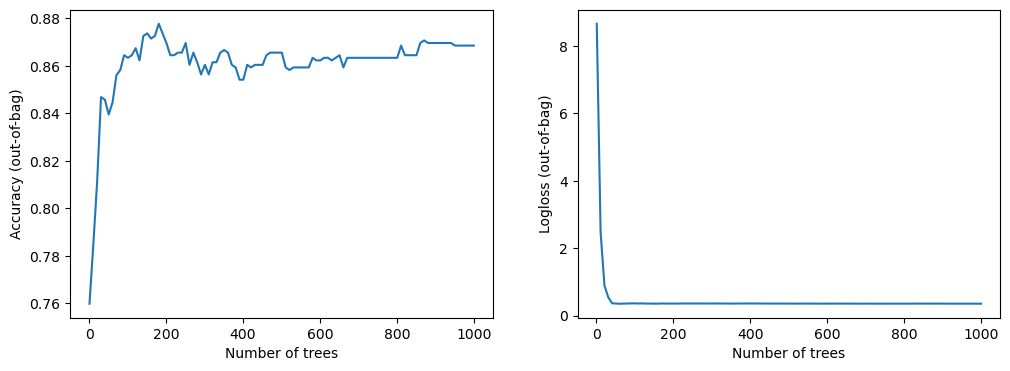

##### Fold 2
Use /tmp/tmpm_q6dgzd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.777191. Found 555 examples.
Training model...
Model trained in 0:00:00.717948
Compiling model...


[INFO 23-07-20 06:11:05.4943 UTC kernel.cc:1242] Loading model from path /tmp/tmpm_q6dgzd/model/ with prefix 7555fa88557b47e4
[INFO 23-07-20 06:11:05.6109 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34512 node(s), and 113 input feature(s).
[INFO 23-07-20 06:11:05.6110 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 531ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3145


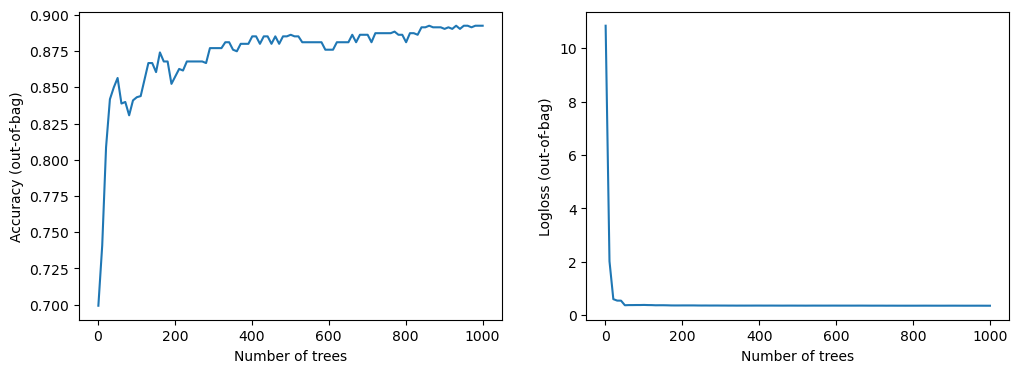

##### Fold 3
Use /tmp/tmp476ac8a4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.822459. Found 555 examples.
Training model...
Model trained in 0:00:00.876100
Compiling model...


[INFO 23-07-20 06:11:11.4879 UTC kernel.cc:1242] Loading model from path /tmp/tmp476ac8a4/model/ with prefix 9f4953380dc14bfb
[INFO 23-07-20 06:11:11.6053 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34332 node(s), and 113 input feature(s).
[INFO 23-07-20 06:11:11.6053 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 06:11:11.6054 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 540ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.4360


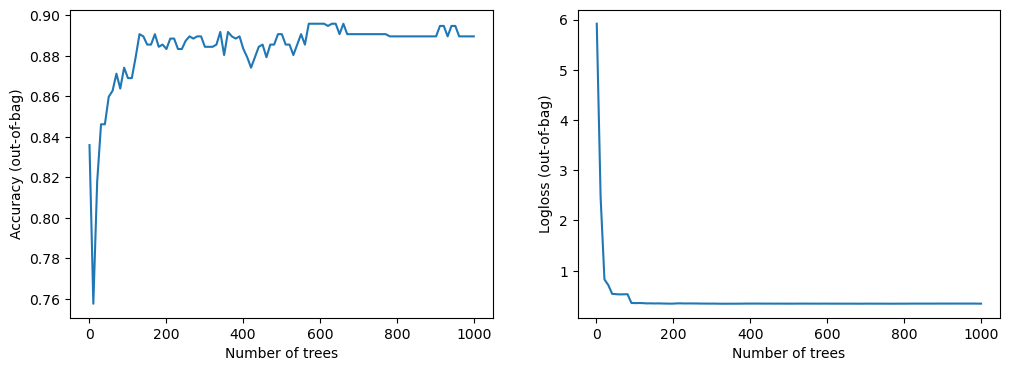

##### Fold 4
Use /tmp/tmpr5lmfepq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.849851. Found 555 examples.
Training model...
Model trained in 0:00:00.693646
Compiling model...


[INFO 23-07-20 06:11:17.8486 UTC kernel.cc:1242] Loading model from path /tmp/tmpr5lmfepq/model/ with prefix 3318128b36784648
[INFO 23-07-20 06:11:17.9609 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34210 node(s), and 113 input feature(s).
[INFO 23-07-20 06:11:17.9609 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 560ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3325


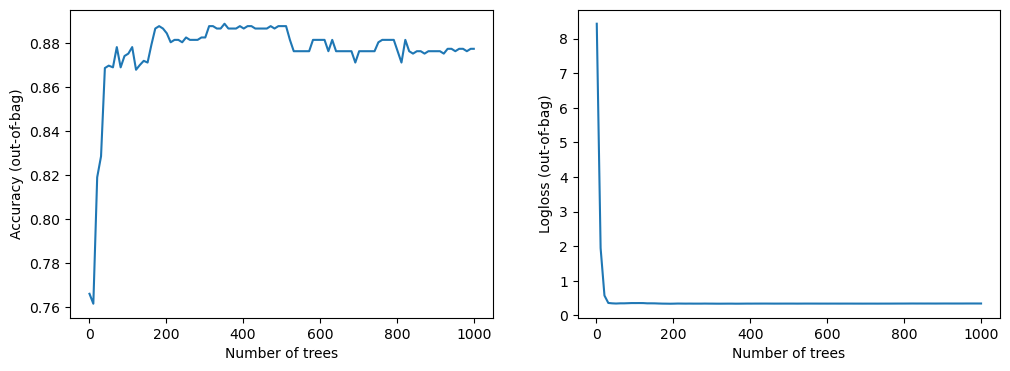

##### Fold 5
Use /tmp/tmpuzd7hoyf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.795354. Found 555 examples.
Training model...
Model trained in 0:00:00.694728
Compiling model...


[INFO 23-07-20 06:11:23.6663 UTC kernel.cc:1242] Loading model from path /tmp/tmpuzd7hoyf/model/ with prefix 098e34d2623e4233
[INFO 23-07-20 06:11:23.7804 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34614 node(s), and 113 input feature(s).
[INFO 23-07-20 06:11:23.7805 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 06:11:23.7805 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 557ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3191


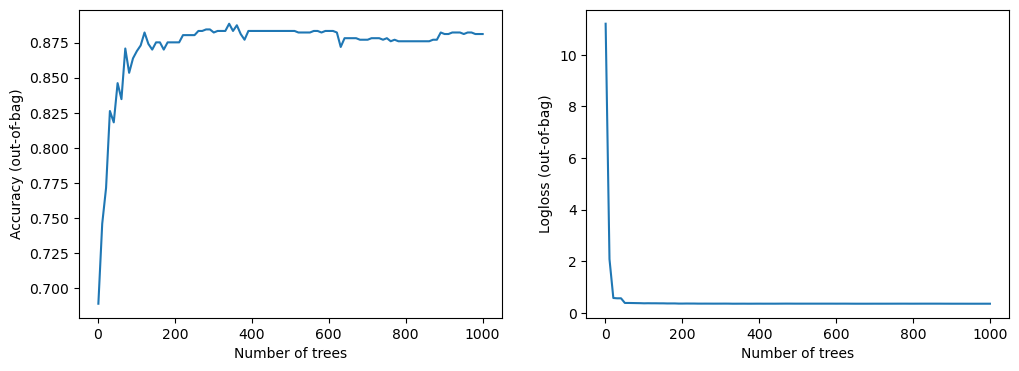

##### Fold 6
Use /tmp/tmpwv33uyhq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.793130. Found 555 examples.
Training model...
Model trained in 0:00:00.691621
Compiling model...


[INFO 23-07-20 06:11:29.4733 UTC kernel.cc:1242] Loading model from path /tmp/tmpwv33uyhq/model/ with prefix d675b135de424eff
[INFO 23-07-20 06:11:29.5858 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34414 node(s), and 113 input feature(s).
[INFO 23-07-20 06:11:29.5859 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 540ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3483


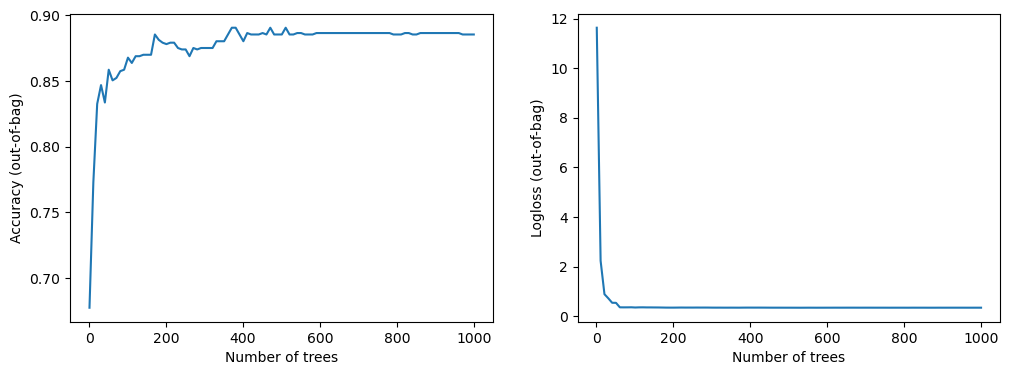

##### Fold 7
Use /tmp/tmpg5r453ij as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.782452. Found 555 examples.
Training model...
Model trained in 0:00:00.701531
Compiling model...


[INFO 23-07-20 06:11:35.2251 UTC kernel.cc:1242] Loading model from path /tmp/tmpg5r453ij/model/ with prefix 2f462d4087b643b3
[INFO 23-07-20 06:11:35.3452 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34550 node(s), and 114 input feature(s).
[INFO 23-07-20 06:11:35.3452 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 06:11:35.3453 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 534ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3973


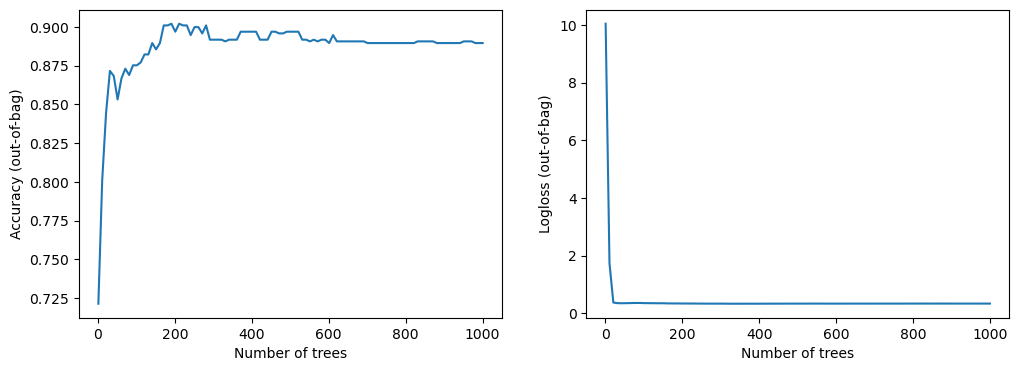

##### Fold 8
Use /tmp/tmp4dwzp750 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.804210. Found 556 examples.
Training model...
Model trained in 0:00:00.694595
Compiling model...


[INFO 23-07-20 06:11:41.0489 UTC kernel.cc:1242] Loading model from path /tmp/tmp4dwzp750/model/ with prefix 1afc1714f10a470d
[INFO 23-07-20 06:11:41.1629 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34432 node(s), and 113 input feature(s).
[INFO 23-07-20 06:11:41.1629 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 547ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3383


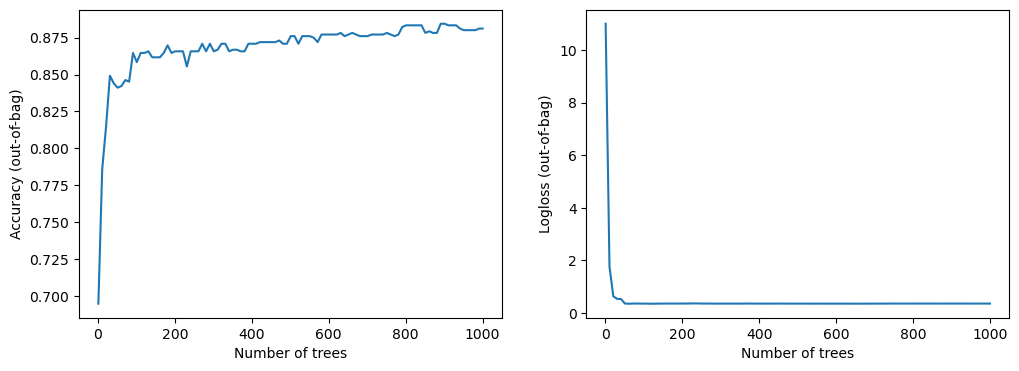

##### Fold 9
Use /tmp/tmpf39keyho as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.813754. Found 556 examples.
Training model...
Model trained in 0:00:00.697129
Compiling model...


[INFO 23-07-20 06:11:47.6941 UTC kernel.cc:1242] Loading model from path /tmp/tmpf39keyho/model/ with prefix 0bb07782c49e43e3
[INFO 23-07-20 06:11:47.8076 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34142 node(s), and 113 input feature(s).
[INFO 23-07-20 06:11:47.8077 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 06:11:47.8077 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 536ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3867


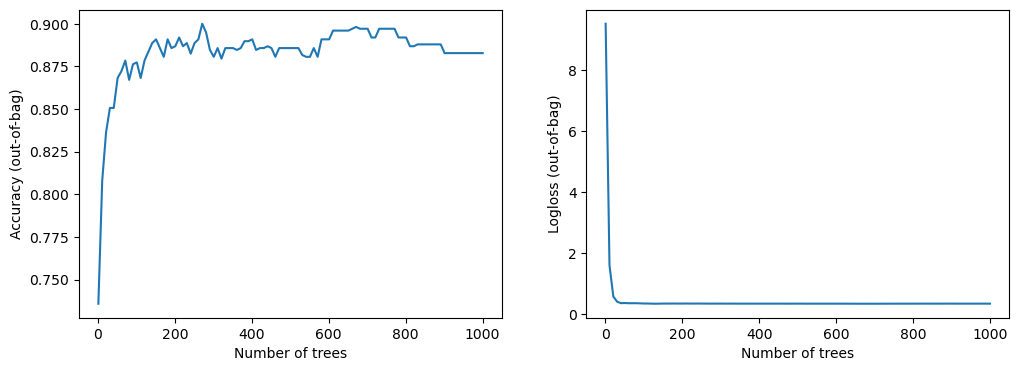

##### Fold 10
Use /tmp/tmpdv4ulptr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.817221. Found 556 examples.
Training model...
Model trained in 0:00:00.696820
Compiling model...


[INFO 23-07-20 06:11:54.0863 UTC kernel.cc:1242] Loading model from path /tmp/tmpdv4ulptr/model/ with prefix 0504959f01364adf
[INFO 23-07-20 06:11:54.2022 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34820 node(s), and 113 input feature(s).
[INFO 23-07-20 06:11:54.2023 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 535ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2814


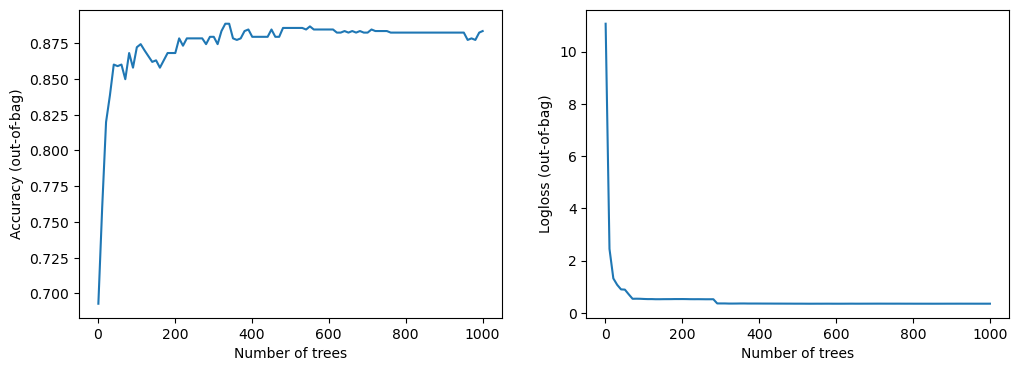


Average accuracy: 0.0000 Average balanced loss: 0.3448


In [17]:
# RandomForestModel
submition_1, model_1,metrics_1 = train_model(
    train=train_out,test=test_out, features=features,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.RandomForestModel,           
    model_kwargs=dict(max_depth=6, num_trees=1000),                                                  
    model_compile_kwargs=dict(metrics=[metrics.accuracy, balanced_logloss_tf]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpat3_f1xg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.787453. Found 555 examples.
Training model...
Model trained in 0:00:00.223506
Compiling model...


[INFO 23-07-20 06:13:09.1112 UTC kernel.cc:1242] Loading model from path /tmp/tmpat3_f1xg/model/ with prefix 5eb256a160044605
[INFO 23-07-20 06:13:09.1462 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10190 node(s), and 112 input feature(s).
[INFO 23-07-20 06:13:09.1463 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 06:13:09.1463 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 543ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3015


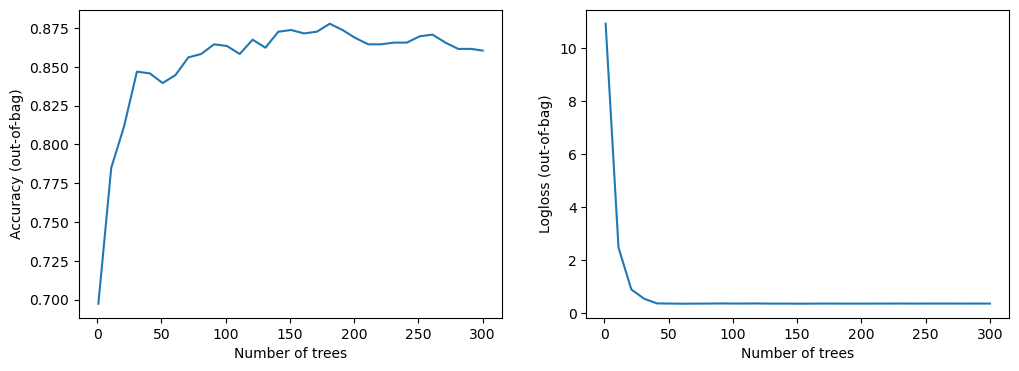

##### Fold 2
Use /tmp/tmp8p7bwucf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.844011. Found 555 examples.
Training model...
Model trained in 0:00:00.223323
Compiling model...


[INFO 23-07-20 06:13:14.4836 UTC kernel.cc:1242] Loading model from path /tmp/tmp8p7bwucf/model/ with prefix e74ca9d2c6eb487a
[INFO 23-07-20 06:13:14.5189 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10330 node(s), and 113 input feature(s).
[INFO 23-07-20 06:13:14.5190 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 544ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3116


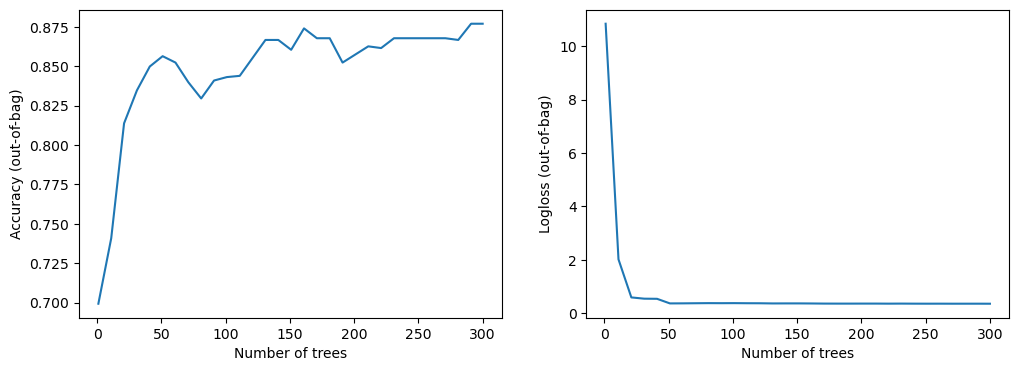

##### Fold 3
Use /tmp/tmpl4u4xgk6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.810081. Found 555 examples.
Training model...
Model trained in 0:00:00.222598
Compiling model...


[INFO 23-07-20 06:13:19.9110 UTC kernel.cc:1242] Loading model from path /tmp/tmpl4u4xgk6/model/ with prefix 2c318ffa556e4465
[INFO 23-07-20 06:13:19.9453 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10300 node(s), and 112 input feature(s).
[INFO 23-07-20 06:13:19.9454 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 06:13:19.9454 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 535ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.4417


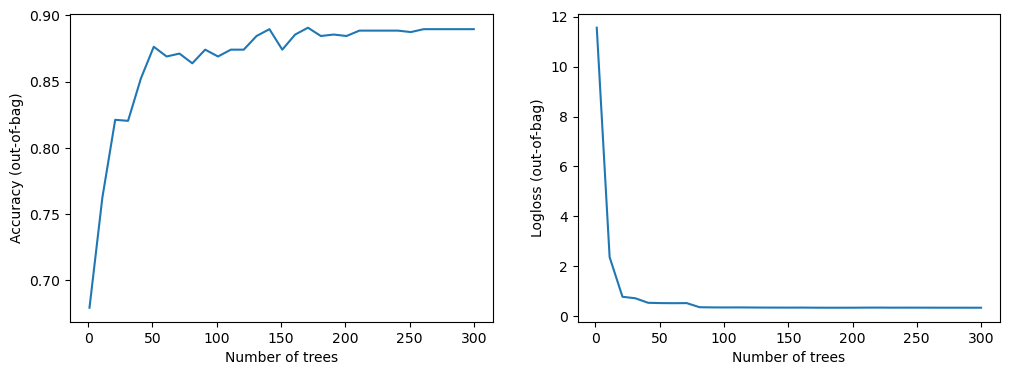

##### Fold 4
Use /tmp/tmpmdoqlt5t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.793470. Found 555 examples.
Training model...
Model trained in 0:00:00.220179
Compiling model...


[INFO 23-07-20 06:13:25.1993 UTC kernel.cc:1242] Loading model from path /tmp/tmpmdoqlt5t/model/ with prefix e6aa09db663c4e5c
[INFO 23-07-20 06:13:25.2336 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10264 node(s), and 111 input feature(s).
[INFO 23-07-20 06:13:25.2337 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 532ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3305


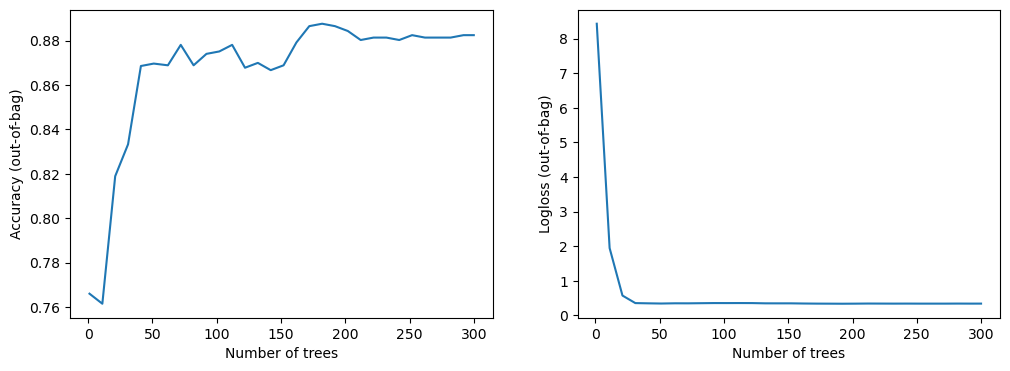

##### Fold 5
Use /tmp/tmpfqp5ke7o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.800109. Found 555 examples.
Training model...
Model trained in 0:00:00.228424
Compiling model...


[INFO 23-07-20 06:13:30.5523 UTC kernel.cc:1242] Loading model from path /tmp/tmpfqp5ke7o/model/ with prefix e8cfcb99857143ea
[INFO 23-07-20 06:13:30.5871 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10450 node(s), and 112 input feature(s).
[INFO 23-07-20 06:13:30.5872 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 06:13:30.5872 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 538ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3279


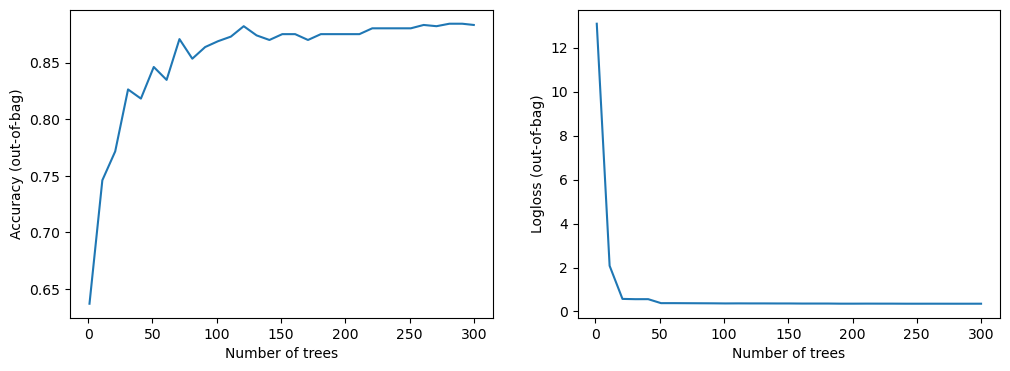

##### Fold 6
Use /tmp/tmp40hcf4p2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.797771. Found 555 examples.
Training model...
Model trained in 0:00:00.229477
Compiling model...


[INFO 23-07-20 06:13:35.8399 UTC kernel.cc:1242] Loading model from path /tmp/tmp40hcf4p2/model/ with prefix a85e8df40b764f16
[INFO 23-07-20 06:13:35.8745 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10332 node(s), and 112 input feature(s).
[INFO 23-07-20 06:13:35.8745 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 528ms/step - loss: 0.0000e+00 - accuracy: 0.0161 - balanced_logloss_tf: nan


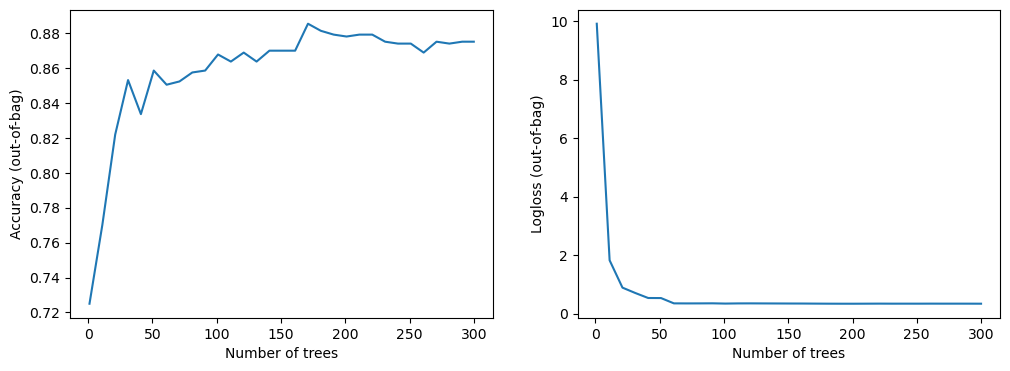

##### Fold 7
Use /tmp/tmpb7mku9ps as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.805150. Found 555 examples.
Training model...
Model trained in 0:00:00.222706
Compiling model...


[INFO 23-07-20 06:13:41.9409 UTC kernel.cc:1242] Loading model from path /tmp/tmpb7mku9ps/model/ with prefix e646755b78064666
[INFO 23-07-20 06:13:41.9754 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10312 node(s), and 112 input feature(s).
[INFO 23-07-20 06:13:41.9755 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 06:13:41.9755 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 540ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.4016


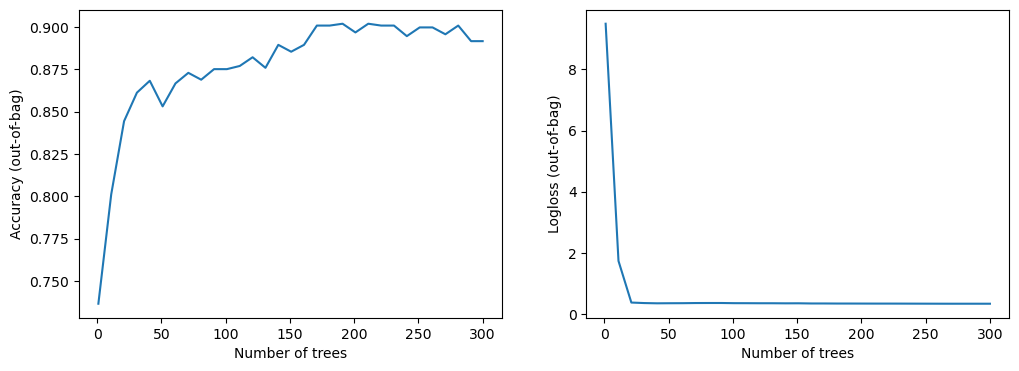

##### Fold 8
Use /tmp/tmpv81pn4db as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.852495. Found 556 examples.
Training model...
Model trained in 0:00:00.278603
Compiling model...


[INFO 23-07-20 06:13:47.3766 UTC kernel.cc:1242] Loading model from path /tmp/tmpv81pn4db/model/ with prefix 164ee9c16b4649e5
[INFO 23-07-20 06:13:47.4160 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10334 node(s), and 112 input feature(s).
[INFO 23-07-20 06:13:47.4161 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 530ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3344


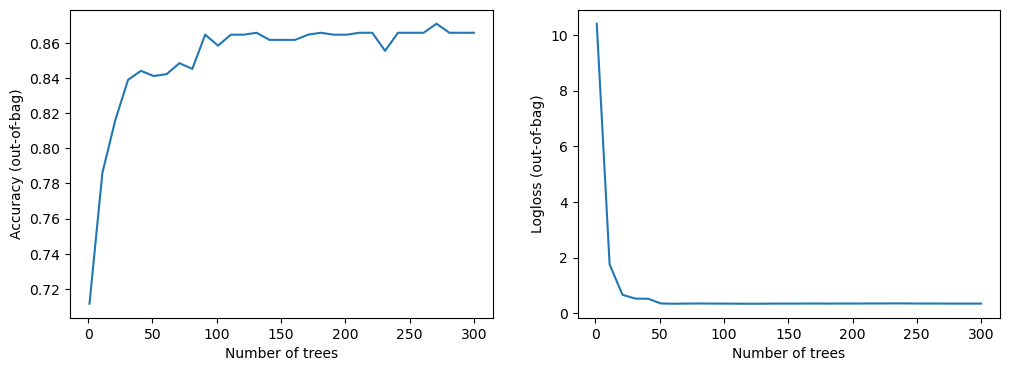

##### Fold 9
Use /tmp/tmp9pqp33bp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.815239. Found 556 examples.
Training model...
Model trained in 0:00:00.226775
Compiling model...


[INFO 23-07-20 06:13:52.7494 UTC kernel.cc:1242] Loading model from path /tmp/tmp9pqp33bp/model/ with prefix c7796acace9e4576
[INFO 23-07-20 06:13:52.7844 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10174 node(s), and 112 input feature(s).
[INFO 23-07-20 06:13:52.7844 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 06:13:52.7845 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 538ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.4160


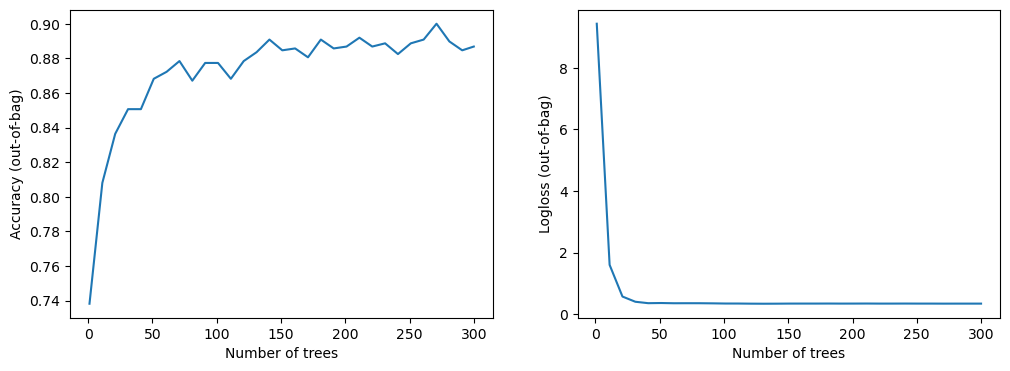

##### Fold 10
Use /tmp/tmplv72uwcj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.822618. Found 556 examples.
Training model...
Model trained in 0:00:00.228267
Compiling model...


[INFO 23-07-20 06:13:58.0721 UTC kernel.cc:1242] Loading model from path /tmp/tmplv72uwcj/model/ with prefix da593dd6e7f849ee
[INFO 23-07-20 06:13:58.1076 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10428 node(s), and 112 input feature(s).
[INFO 23-07-20 06:13:58.1076 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 529ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2804


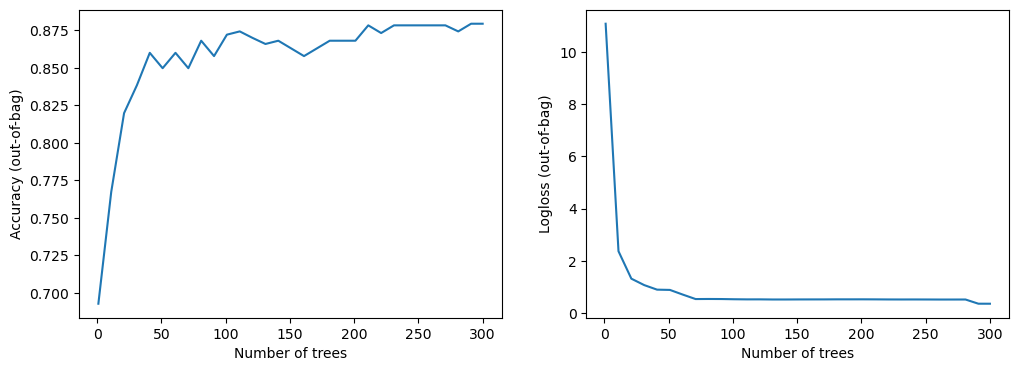


Average accuracy: 0.0016 Average balanced loss: 0.3495


In [18]:
# RandomForestModel
submition_2, model_2,metrics_2 = train_model(
    train=train_out,test=test_out, features=features,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.RandomForestModel,           
    model_kwargs=dict(max_depth=6, num_trees=300),                                                  
    model_compile_kwargs=dict(metrics=[metrics.accuracy, balanced_logloss_tf]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpjo1_gr5j as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.103677. Found 555 examples.
Training model...
Model trained in 0:00:00.171215
Compiling model...


[INFO 23-07-20 06:32:42.7167 UTC kernel.cc:1242] Loading model from path /tmp/tmpjo1_gr5j/model/ with prefix 7a121b37496b408f
[INFO 23-07-20 06:32:42.7542 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11186 node(s), and 58 input feature(s).
[INFO 23-07-20 06:32:42.7542 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 06:32:42.7543 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 388ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2470


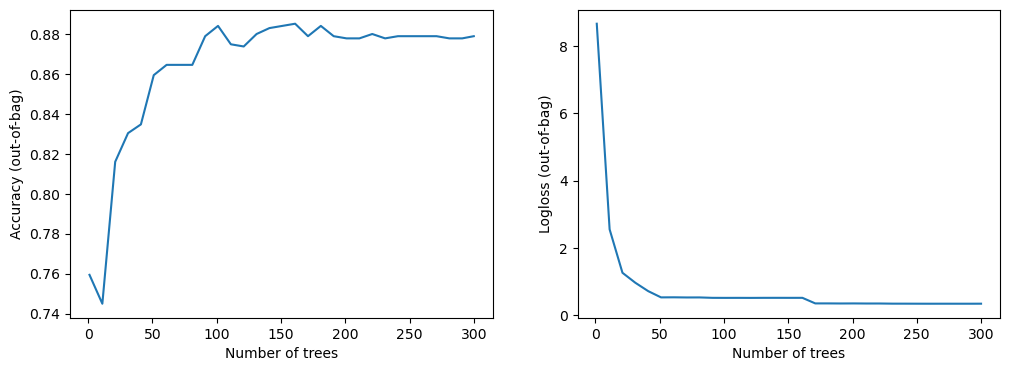

##### Fold 2
Use /tmp/tmpc68eluo4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.095058. Found 555 examples.
Training model...
Model trained in 0:00:00.169883
Compiling model...


[INFO 23-07-20 06:32:46.7554 UTC kernel.cc:1242] Loading model from path /tmp/tmpc68eluo4/model/ with prefix 535034c9fcd7418c
[INFO 23-07-20 06:32:46.7922 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11246 node(s), and 58 input feature(s).
[INFO 23-07-20 06:32:46.7922 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 389ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2757


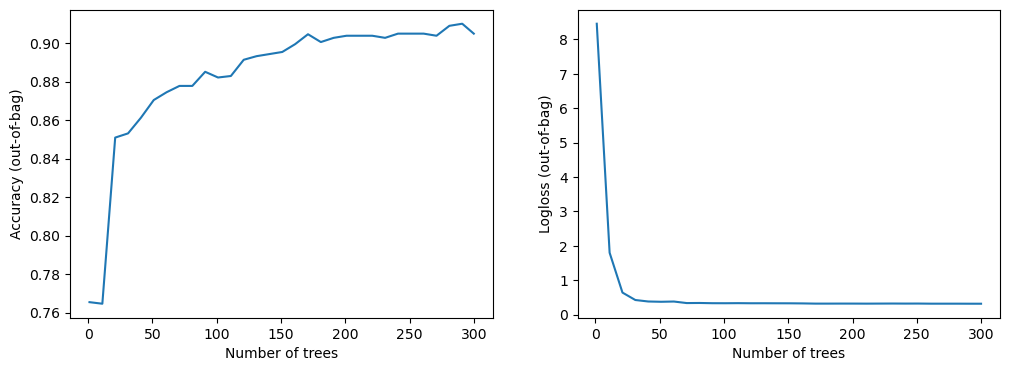

##### Fold 3
Use /tmp/tmpbful2xxy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.061424. Found 555 examples.
Training model...
Model trained in 0:00:00.169476
Compiling model...


[INFO 23-07-20 06:32:50.7741 UTC kernel.cc:1242] Loading model from path /tmp/tmpbful2xxy/model/ with prefix b78fb7e1480d4ddf
[INFO 23-07-20 06:32:50.8103 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11012 node(s), and 58 input feature(s).
[INFO 23-07-20 06:32:50.8103 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 389ms/step - loss: 0.0000e+00 - accuracy: 0.0323 - balanced_logloss_tf: nan


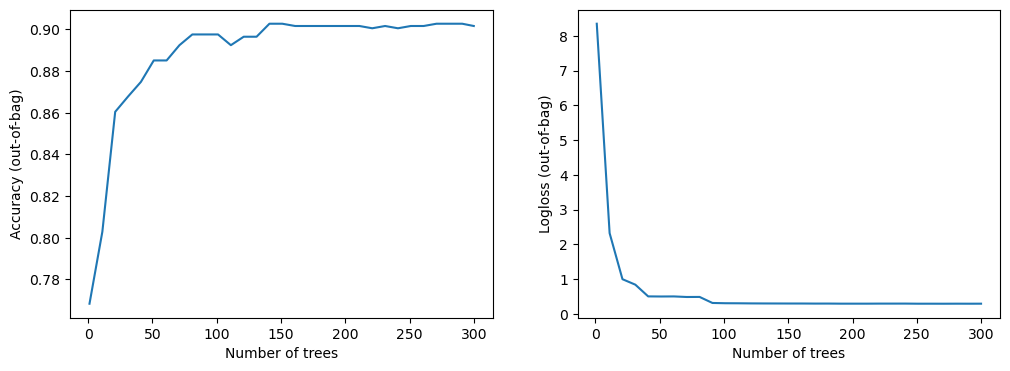

##### Fold 4
Use /tmp/tmpeo5wk5bq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.061220. Found 555 examples.
Training model...
Model trained in 0:00:00.174540
Compiling model...


[INFO 23-07-20 06:32:54.2529 UTC kernel.cc:1242] Loading model from path /tmp/tmpeo5wk5bq/model/ with prefix c86c3992469b43c2
[INFO 23-07-20 06:32:54.2903 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11246 node(s), and 58 input feature(s).
[INFO 23-07-20 06:32:54.2903 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 06:32:54.2903 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 404ms/step - loss: 0.0000e+00 - accuracy: 0.0161 - balanced_logloss_tf: nan


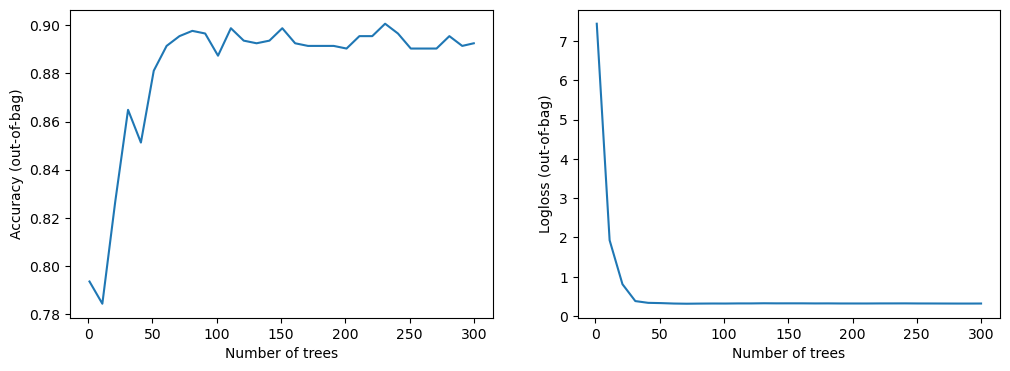

##### Fold 5
Use /tmp/tmpviutuawz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.073591. Found 555 examples.
Training model...
Model trained in 0:00:00.173436
Compiling model...


[INFO 23-07-20 06:32:58.2807 UTC kernel.cc:1242] Loading model from path /tmp/tmpviutuawz/model/ with prefix 0382bb6dd2114263
[INFO 23-07-20 06:32:58.3184 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11294 node(s), and 58 input feature(s).
[INFO 23-07-20 06:32:58.3184 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 0.0161 - balanced_logloss_tf: nan


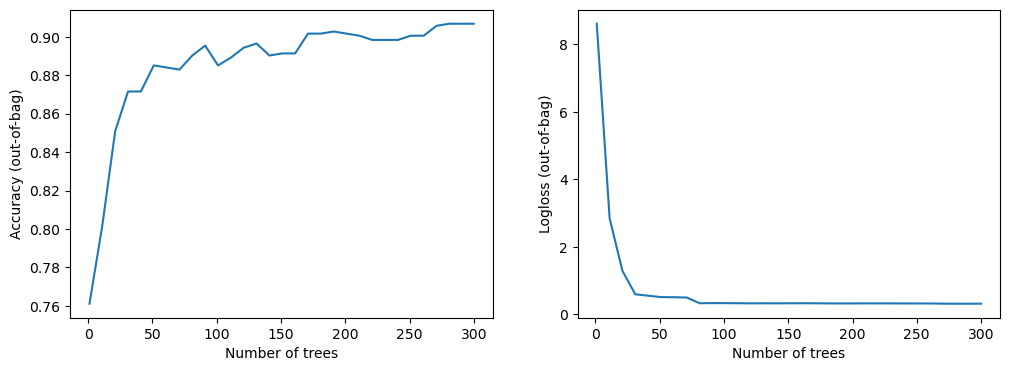

##### Fold 6
Use /tmp/tmpsglggu9r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.074350. Found 555 examples.
Training model...
Model trained in 0:00:00.175350
Compiling model...


[INFO 23-07-20 06:33:02.5843 UTC kernel.cc:1242] Loading model from path /tmp/tmpsglggu9r/model/ with prefix 17f66b0ec0284c28
[INFO 23-07-20 06:33:02.6214 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11238 node(s), and 58 input feature(s).
[INFO 23-07-20 06:33:02.6214 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 388ms/step - loss: 0.0000e+00 - accuracy: 0.0161 - balanced_logloss_tf: nan


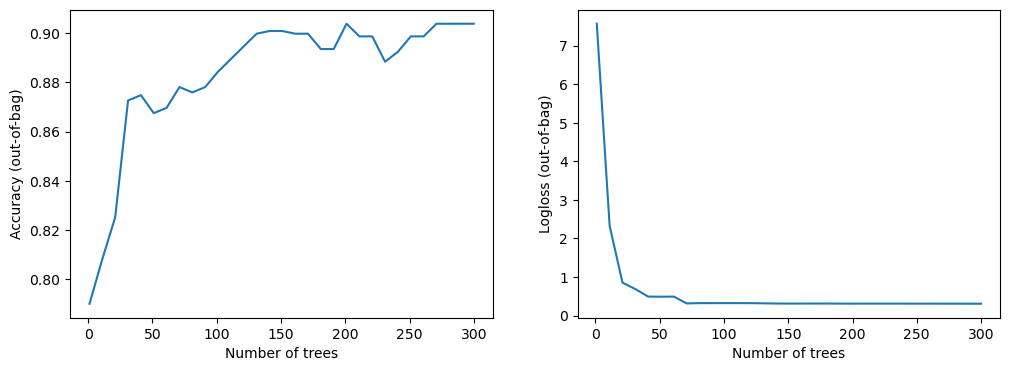

##### Fold 7
Use /tmp/tmp33xd_zzd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.122451. Found 555 examples.
Training model...
Model trained in 0:00:00.206903
Compiling model...


[INFO 23-07-20 06:33:06.1595 UTC kernel.cc:1242] Loading model from path /tmp/tmp33xd_zzd/model/ with prefix ed9fd879126b461d
[INFO 23-07-20 06:33:06.1980 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11262 node(s), and 59 input feature(s).
[INFO 23-07-20 06:33:06.1981 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 06:33:06.1981 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 383ms/step - loss: 0.0000e+00 - accuracy: 0.0161 - balanced_logloss_tf: nan


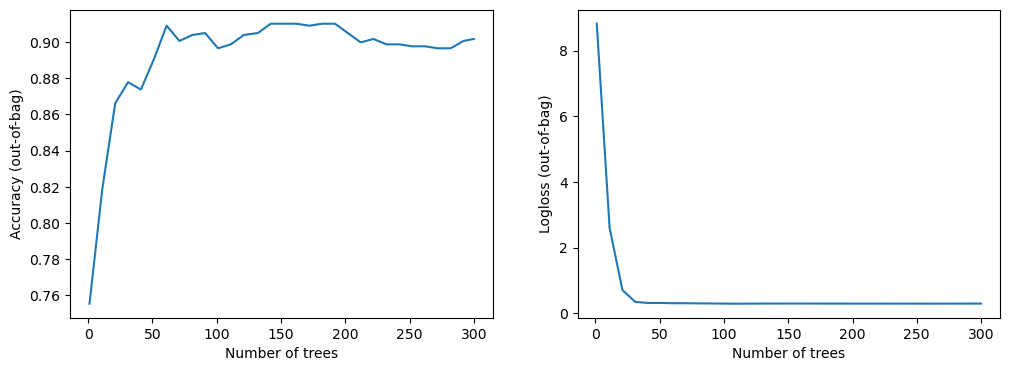

##### Fold 8
Use /tmp/tmprcfpu95_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.098102. Found 556 examples.
Training model...
Model trained in 0:00:00.173139
Compiling model...


[INFO 23-07-20 06:33:10.1326 UTC kernel.cc:1242] Loading model from path /tmp/tmprcfpu95_/model/ with prefix 6a9afa5aecfd4233
[INFO 23-07-20 06:33:10.1698 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11146 node(s), and 58 input feature(s).
[INFO 23-07-20 06:33:10.1699 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 385ms/step - loss: 0.0000e+00 - accuracy: 0.0328 - balanced_logloss_tf: nan


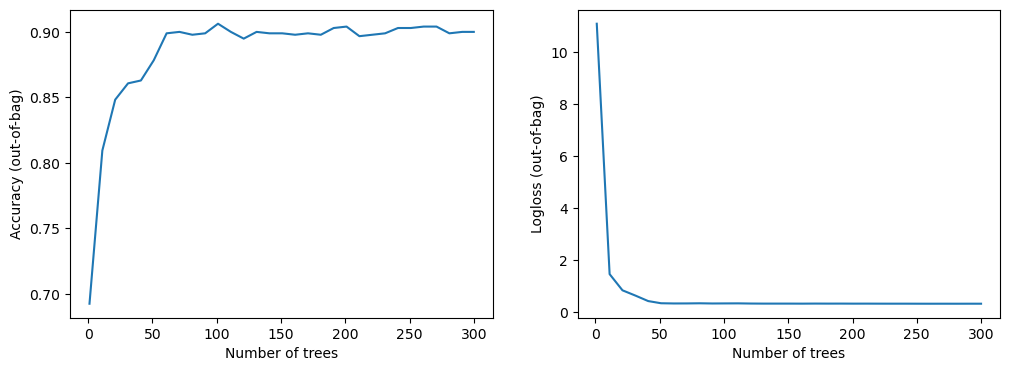

##### Fold 9
Use /tmp/tmpoxlxguvy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.083287. Found 556 examples.
Training model...
Model trained in 0:00:00.170093
Compiling model...


[INFO 23-07-20 06:33:13.6250 UTC kernel.cc:1242] Loading model from path /tmp/tmpoxlxguvy/model/ with prefix 1a20036851d04334
[INFO 23-07-20 06:33:13.6618 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11126 node(s), and 58 input feature(s).
[INFO 23-07-20 06:33:13.6619 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 399ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3449


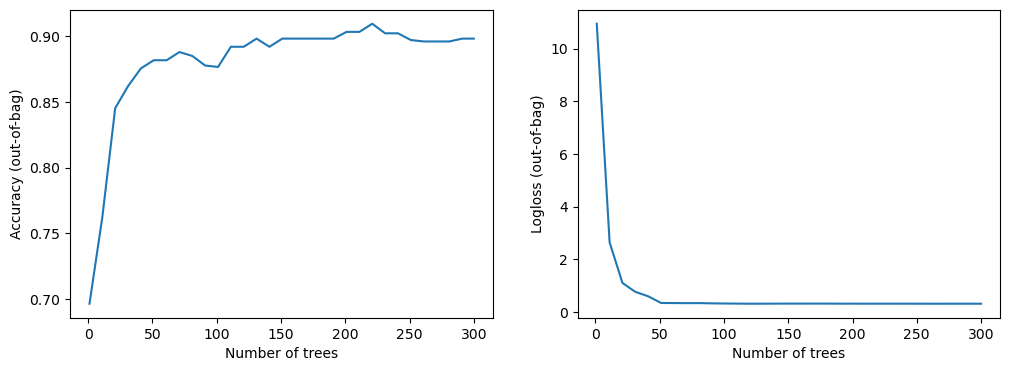

##### Fold 10
Use /tmp/tmp1y2q_qbl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.097883. Found 556 examples.
Training model...
Model trained in 0:00:00.172706
Compiling model...


[INFO 23-07-20 06:33:17.1618 UTC kernel.cc:1242] Loading model from path /tmp/tmp1y2q_qbl/model/ with prefix aad163c629a74729
[INFO 23-07-20 06:33:17.1983 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11154 node(s), and 58 input feature(s).
[INFO 23-07-20 06:33:17.1984 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 06:33:17.1984 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 382ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2687


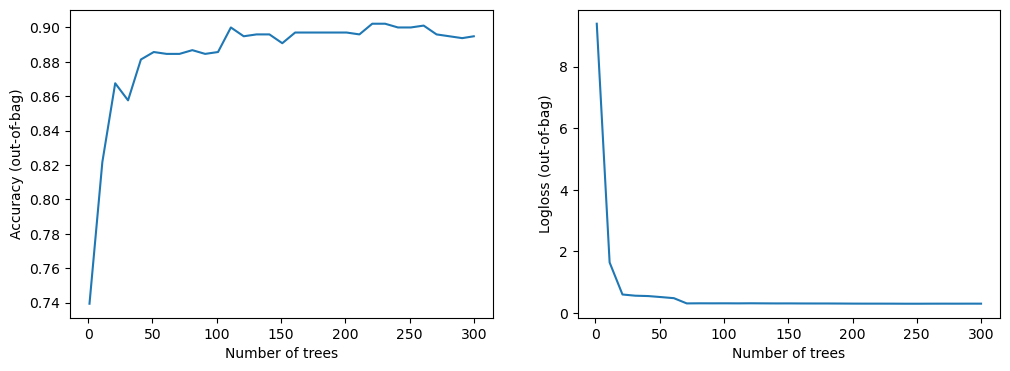


Average accuracy: 0.0130 Average balanced loss: 0.2840


In [21]:
# RandomForestModel

features_slice = [i for i in features if len(i) > 2]

submition_3, model_3,metrics_3 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.RandomForestModel,           
    model_kwargs=dict(max_depth=6, num_trees=300),                                                  
    model_compile_kwargs=dict(metrics=[metrics.accuracy, balanced_logloss_tf]))

# GradientBoostedTreesModel

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpbqyw40z7 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:44:10.7108 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:10.7108 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:10.7108 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.105475. Found 555 examples.
Training model...
Model trained in 0:00:01.906725
Compiling model...


[INFO 23-07-20 06:44:13.7137 UTC kernel.cc:1242] Loading model from path /tmp/tmpbqyw40z7/model/ with prefix de58c166810e4807
[INFO 23-07-20 06:44:13.7308 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 06:44:13.7309 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 399ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.0299


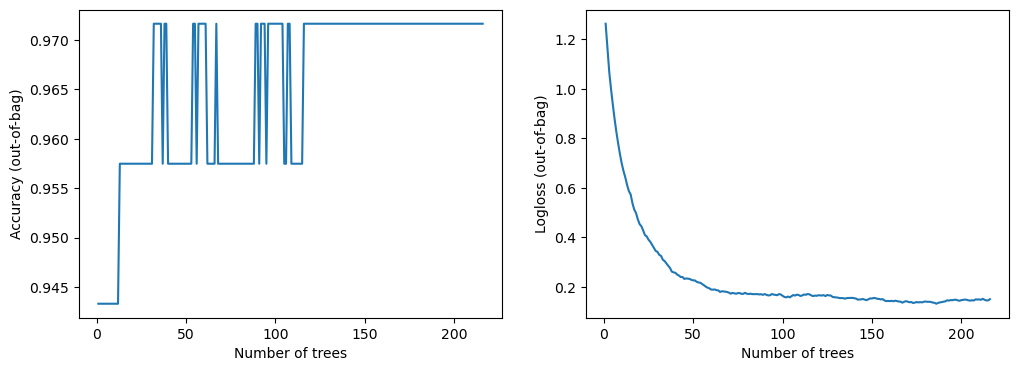

##### Fold 2
Use /tmp/tmpp5vmsv0r as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:44:15.9676 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:15.9677 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:15.9677 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.141747. Found 555 examples.
Training model...
Model trained in 0:00:01.717001
Compiling model...


[INFO 23-07-20 06:44:18.8212 UTC kernel.cc:1242] Loading model from path /tmp/tmpp5vmsv0r/model/ with prefix 6c1851af431d46de
[INFO 23-07-20 06:44:18.8368 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.1438


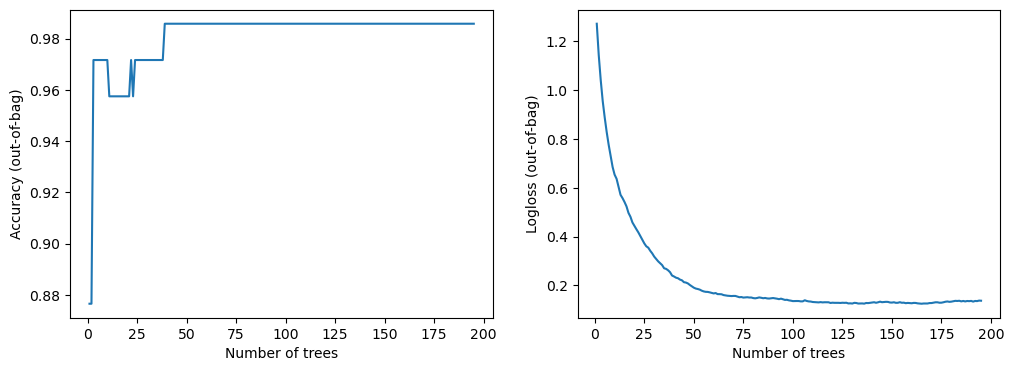

##### Fold 3
Use /tmp/tmpdcrhh883 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:44:22.6793 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:22.6794 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:22.6794 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.162037. Found 555 examples.
Training model...
Model trained in 0:00:02.214136
Compiling model...


[INFO 23-07-20 06:44:26.0412 UTC kernel.cc:1242] Loading model from path /tmp/tmpdcrhh883/model/ with prefix f52009f76c224342
[INFO 23-07-20 06:44:26.0626 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 06:44:26.0626 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 391ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.8838


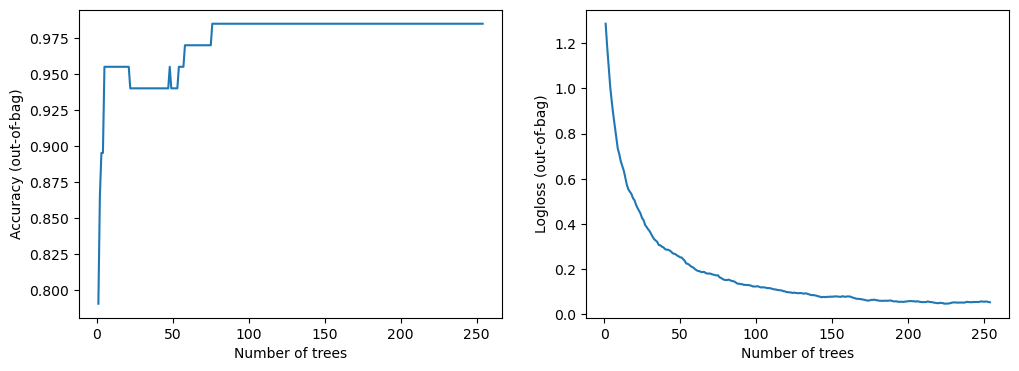

##### Fold 4
Use /tmp/tmpqnkjjvk1 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:44:28.3432 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:28.3432 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:28.3433 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.096406. Found 555 examples.
Training model...
Model trained in 0:00:02.279101
Compiling model...


[INFO 23-07-20 06:44:31.7057 UTC kernel.cc:1242] Loading model from path /tmp/tmpqnkjjvk1/model/ with prefix 23ba8c9d8b6049de
[INFO 23-07-20 06:44:31.7273 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 389ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3553


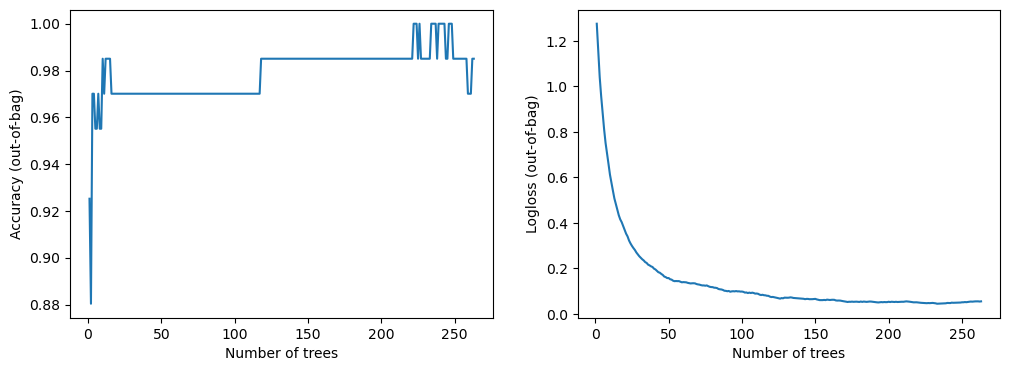

##### Fold 5
Use /tmp/tmp53f36hib as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:44:33.9459 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:33.9461 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:33.9463 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.131037. Found 555 examples.
Training model...
Model trained in 0:00:02.406524
Compiling model...


[INFO 23-07-20 06:44:37.4688 UTC kernel.cc:1242] Loading model from path /tmp/tmp53f36hib/model/ with prefix e3b4e101374a4aec
[INFO 23-07-20 06:44:37.4916 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 06:44:37.4917 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 386ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.5371


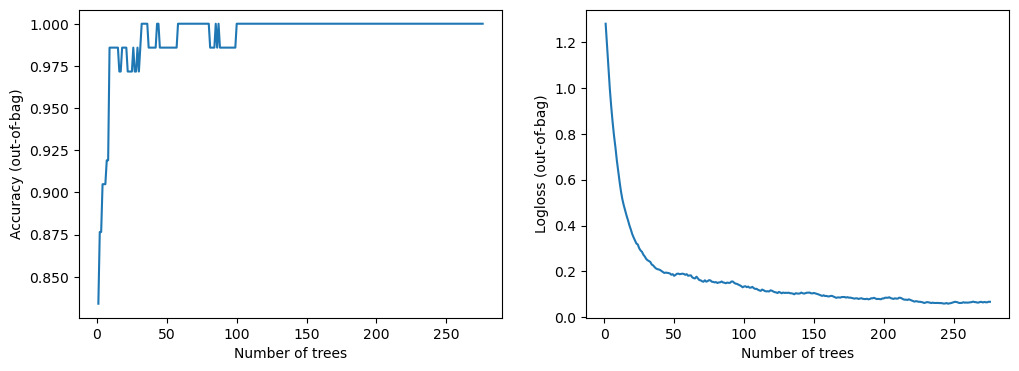

##### Fold 6
Use /tmp/tmptwum2bf6 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:44:39.7116 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:39.7117 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:39.7117 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.099463. Found 555 examples.
Training model...
Model trained in 0:00:01.236400
Compiling model...


[INFO 23-07-20 06:44:42.0455 UTC kernel.cc:1242] Loading model from path /tmp/tmptwum2bf6/model/ with prefix 0cf9863fd3344eb5
[INFO 23-07-20 06:44:42.0564 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 383ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2998


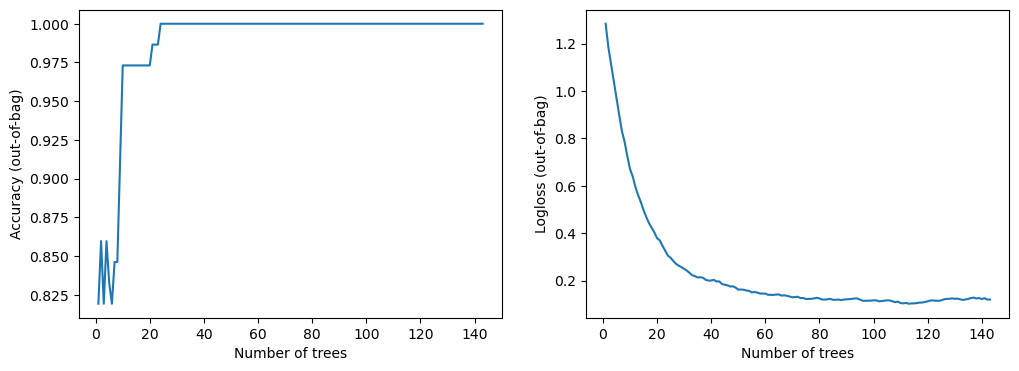

##### Fold 7
Use /tmp/tmpnlctk3zn as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:44:44.2824 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:44.2825 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:44.2825 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.088148. Found 555 examples.
Training model...
Model trained in 0:00:00.571084
Compiling model...


[INFO 23-07-20 06:44:45.9480 UTC kernel.cc:1242] Loading model from path /tmp/tmpnlctk3zn/model/ with prefix 54971ec1425541c1
[INFO 23-07-20 06:44:45.9517 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 381ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3052


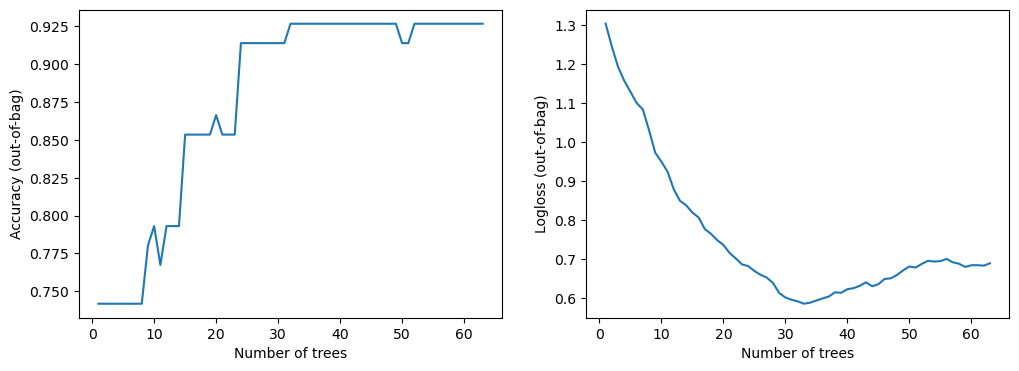

##### Fold 8
Use /tmp/tmpk3z2kf1v as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:44:48.2664 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:48.2664 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:48.2664 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.092857. Found 556 examples.
Training model...
Model trained in 0:00:00.581144
Compiling model...


[INFO 23-07-20 06:44:49.9444 UTC kernel.cc:1242] Loading model from path /tmp/tmpk3z2kf1v/model/ with prefix 1bbaf0ee325848cc
[INFO 23-07-20 06:44:49.9484 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 06:44:49.9485 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 384ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3190


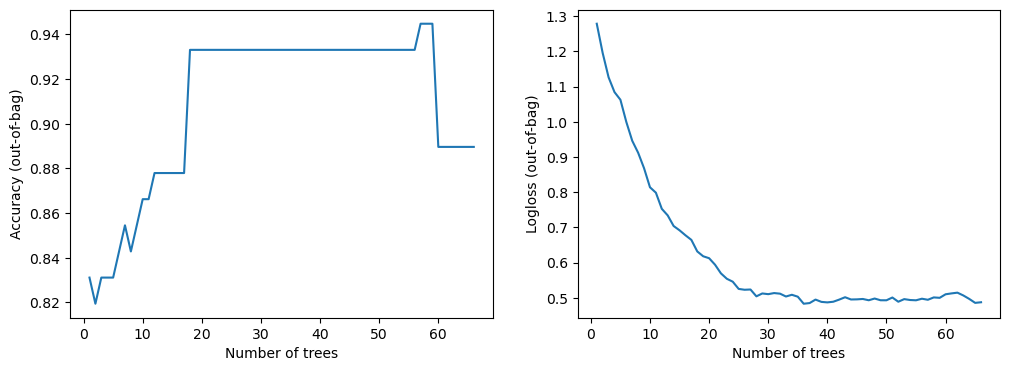

##### Fold 9
Use /tmp/tmpf2nph6vt as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:44:52.2484 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:52.2484 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:52.2484 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.096472. Found 556 examples.
Training model...
Model trained in 0:00:00.911683
Compiling model...


[INFO 23-07-20 06:44:54.2574 UTC kernel.cc:1242] Loading model from path /tmp/tmpf2nph6vt/model/ with prefix 204c982688bf42f5
[INFO 23-07-20 06:44:54.2647 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 415ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.4456


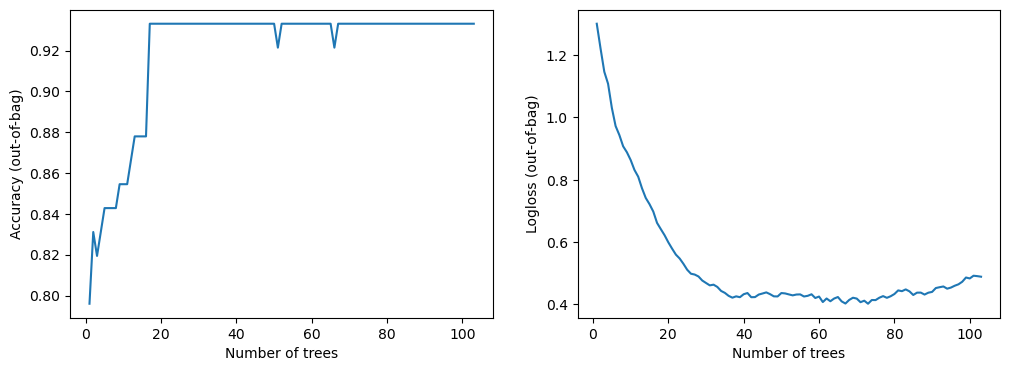

##### Fold 10
Use /tmp/tmp3gp8t3th as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:44:57.5560 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:57.5560 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:44:57.5561 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.108371. Found 556 examples.
Training model...
Model trained in 0:00:00.578227
Compiling model...


[INFO 23-07-20 06:44:59.2481 UTC kernel.cc:1242] Loading model from path /tmp/tmp3gp8t3th/model/ with prefix f89d2f5999134d02
[INFO 23-07-20 06:44:59.2519 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 386ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2912


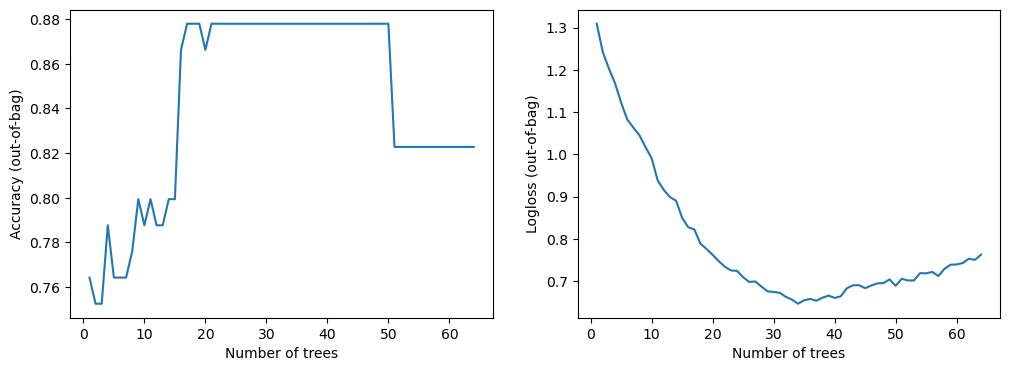


Average accuracy: 0.0000 Average balanced loss: 0.3611


In [24]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

submition_4, model_4,metrics_4 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.GradientBoostedTreesModel,            
    model_kwargs=dict(max_depth=5, num_trees=1000),                                                  
    model_compile_kwargs=dict(metrics=[metrics.accuracy, balanced_logloss_tf]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmp1ae45rw1 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:47:49.4594 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:47:49.4595 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:47:49.4595 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.108275. Found 555 examples.
Training model...
Model trained in 0:00:00.974229
Compiling model...


[INFO 23-07-20 06:47:51.5415 UTC kernel.cc:1242] Loading model from path /tmp/tmp1ae45rw1/model/ with prefix 2aa368a9b06b475e
[INFO 23-07-20 06:47:51.5504 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 06:47:51.5504 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 391ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.1640


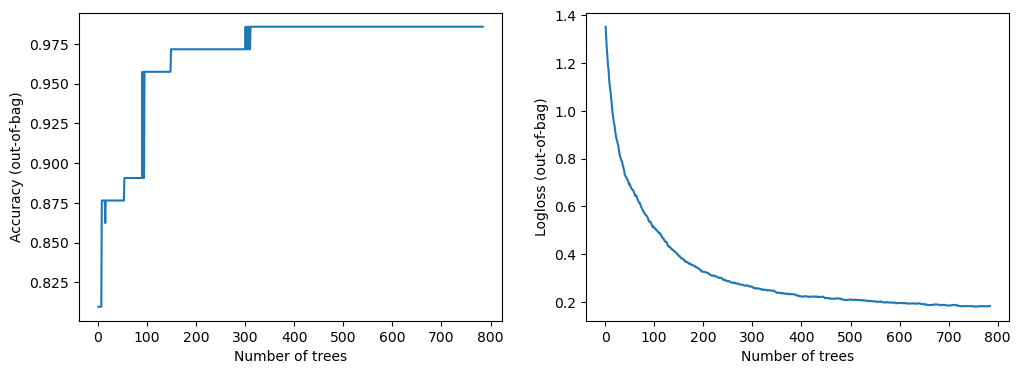

##### Fold 2
Use /tmp/tmpw6mxoh0d as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:47:53.8043 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:47:53.8043 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:47:53.8043 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.115307. Found 555 examples.
Training model...
Model trained in 0:00:00.593521
Compiling model...


[INFO 23-07-20 06:47:55.5156 UTC kernel.cc:1242] Loading model from path /tmp/tmpw6mxoh0d/model/ with prefix f617ea7686a74ed9
[INFO 23-07-20 06:47:55.5211 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 405ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.1576


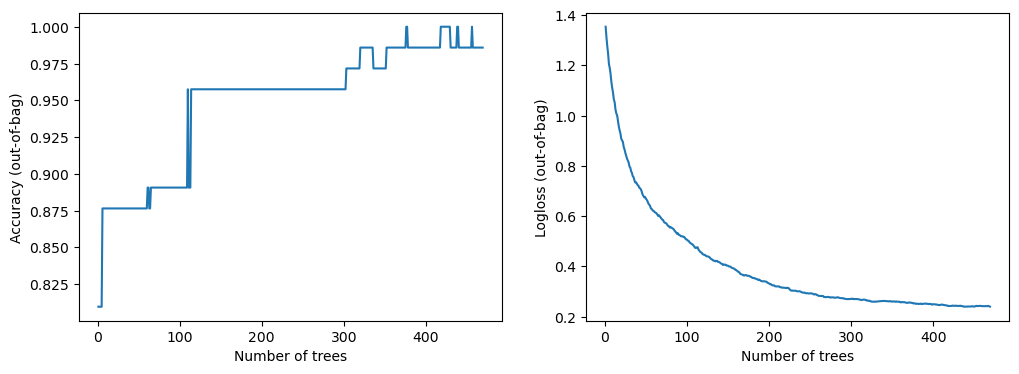

##### Fold 3
Use /tmp/tmpuxmr9ofi as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:47:57.7517 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:47:57.7518 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:47:57.7518 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.103504. Found 555 examples.
Training model...
Model trained in 0:00:00.677773
Compiling model...


[INFO 23-07-20 06:47:59.5353 UTC kernel.cc:1242] Loading model from path /tmp/tmpuxmr9ofi/model/ with prefix b4f0caa561424a3b
[INFO 23-07-20 06:47:59.5416 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 395ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3384


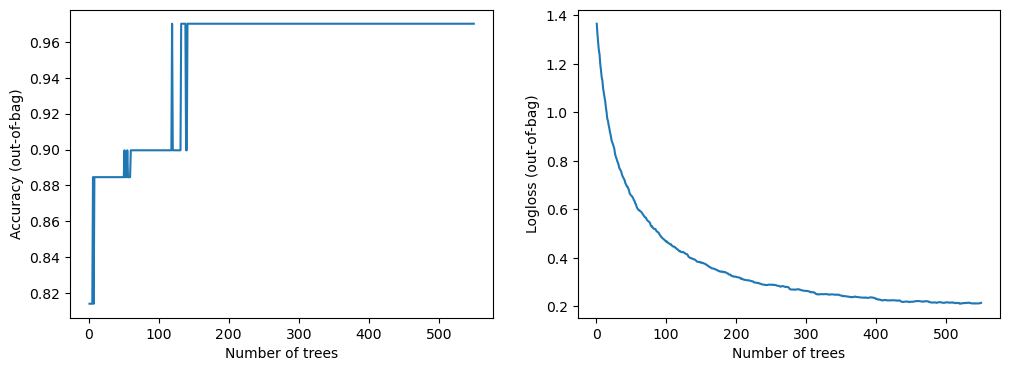

##### Fold 4
Use /tmp/tmp_5du4jxk as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:48:01.7652 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:48:01.7652 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:48:01.7652 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.118218. Found 555 examples.
Training model...
Model trained in 0:00:00.587517
Compiling model...


[INFO 23-07-20 06:48:03.4754 UTC kernel.cc:1242] Loading model from path /tmp/tmp_5du4jxk/model/ with prefix f3cc2f0b69bf4529
[INFO 23-07-20 06:48:03.4810 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 06:48:03.4811 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 383ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2671


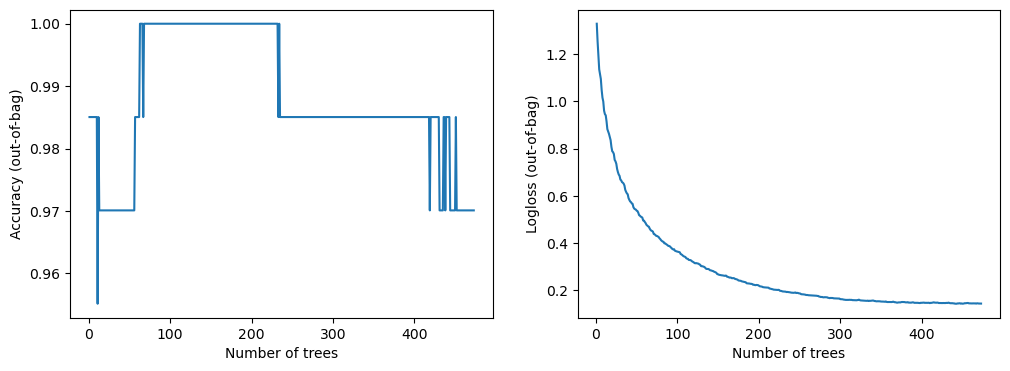

##### Fold 5
Use /tmp/tmp7yiwzcdd as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:48:05.6350 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:48:05.6350 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:48:05.6350 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.120625. Found 555 examples.
Training model...
Model trained in 0:00:00.906396
Compiling model...


[INFO 23-07-20 06:48:07.6615 UTC kernel.cc:1242] Loading model from path /tmp/tmp7yiwzcdd/model/ with prefix 828ed679263d4a6b
[INFO 23-07-20 06:48:07.6698 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 401ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2613


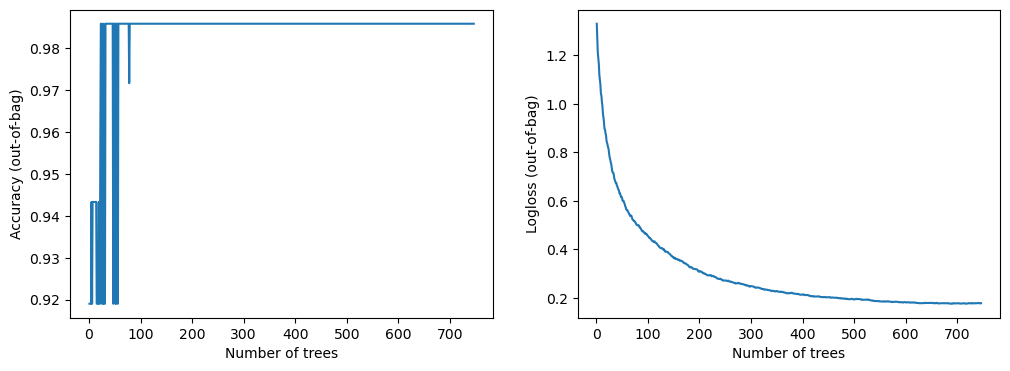

##### Fold 6
Use /tmp/tmpkabmmv6a as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:48:09.8805 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:48:09.8807 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:48:09.8809 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.115448. Found 555 examples.
Training model...
Model trained in 0:00:01.069980
Compiling model...


[INFO 23-07-20 06:48:12.0644 UTC kernel.cc:1242] Loading model from path /tmp/tmpkabmmv6a/model/ with prefix f8e849324b034889
[INFO 23-07-20 06:48:12.0741 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 394ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2744


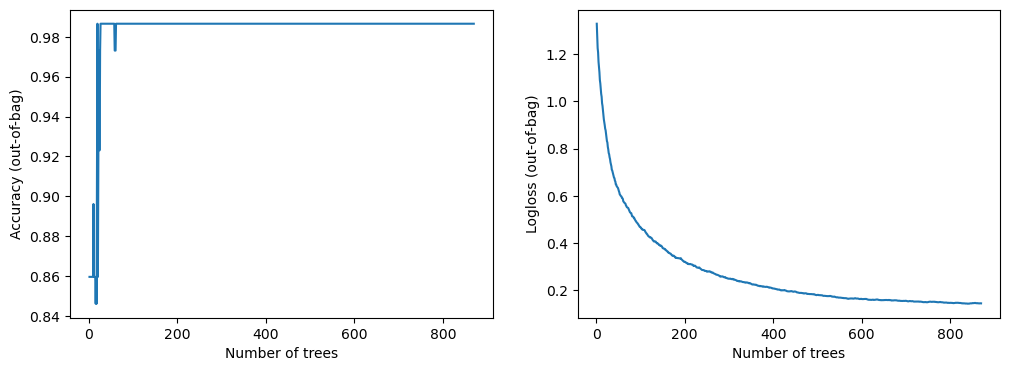

##### Fold 7
Use /tmp/tmpafh1h341 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:48:14.3492 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:48:14.3493 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:48:14.3494 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.115178. Found 555 examples.
Training model...
Model trained in 0:00:00.516639
Compiling model...


[INFO 23-07-20 06:48:15.9848 UTC kernel.cc:1242] Loading model from path /tmp/tmpafh1h341/model/ with prefix 6a6b19b0e6ec4f78
[INFO 23-07-20 06:48:15.9895 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 06:48:15.9895 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 391ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2420


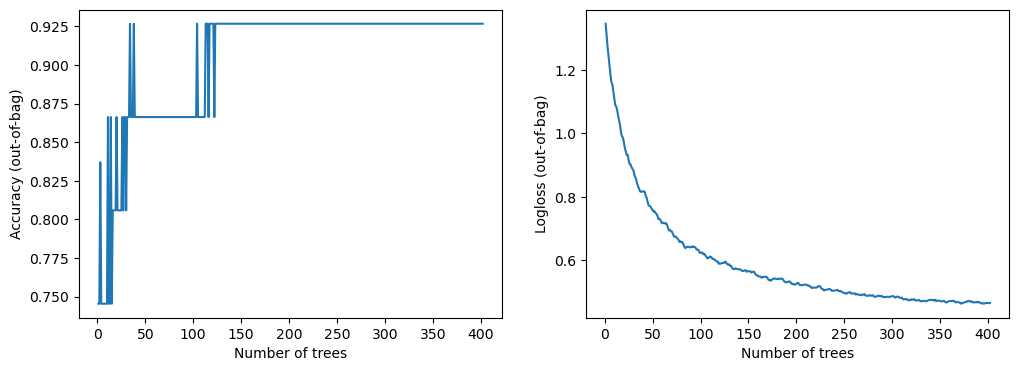

##### Fold 8
Use /tmp/tmprq_0atat as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:48:18.2315 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:48:18.2316 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:48:18.2316 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.117108. Found 556 examples.
Training model...
Model trained in 0:00:00.512940
Compiling model...


[INFO 23-07-20 06:48:19.8647 UTC kernel.cc:1242] Loading model from path /tmp/tmprq_0atat/model/ with prefix 27516646f9c04edd
[INFO 23-07-20 06:48:19.8695 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 403ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2632


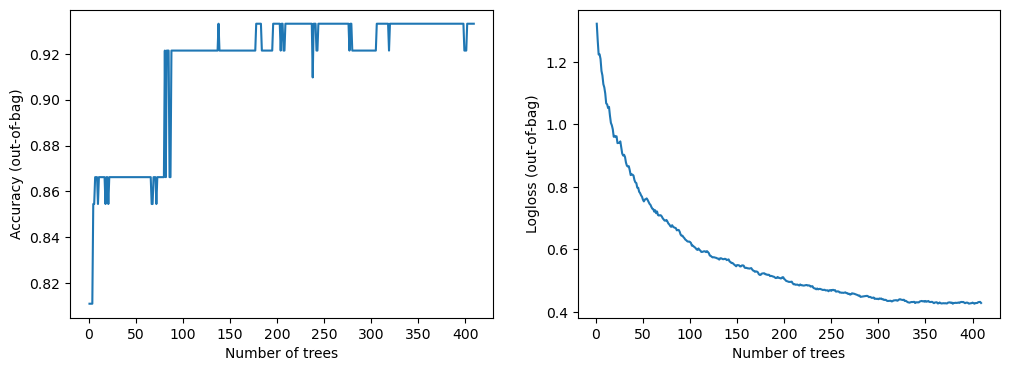

##### Fold 9
Use /tmp/tmp7kbrhs4x as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:48:23.5917 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:48:23.5917 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:48:23.5918 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.139409. Found 556 examples.
Training model...
Model trained in 0:00:00.720711
Compiling model...


[INFO 23-07-20 06:48:25.4536 UTC kernel.cc:1242] Loading model from path /tmp/tmp7kbrhs4x/model/ with prefix 307acbde0f774898
[INFO 23-07-20 06:48:25.4600 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 398ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3122


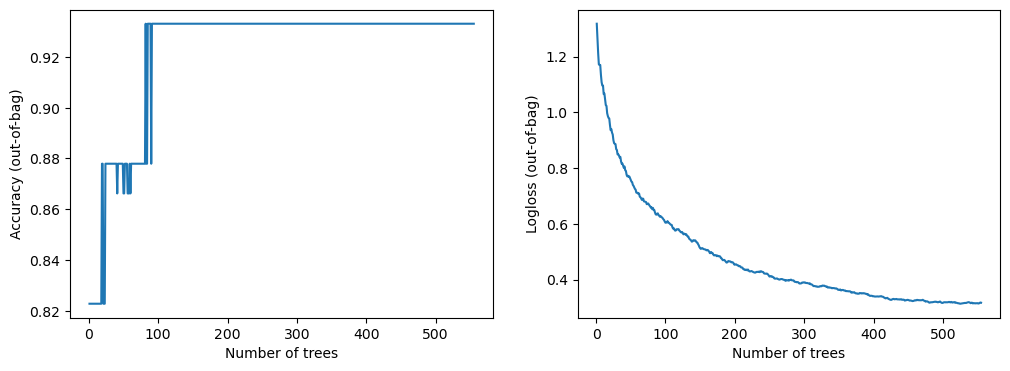

##### Fold 10
Use /tmp/tmpbbdsl2cn as temporary training directory
Reading training dataset...


[WARNING 23-07-20 06:48:27.6990 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:48:27.6990 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 06:48:27.6991 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.098530. Found 556 examples.
Training model...
Model trained in 0:00:00.550690
Compiling model...


[INFO 23-07-20 06:48:29.3533 UTC kernel.cc:1242] Loading model from path /tmp/tmpbbdsl2cn/model/ with prefix c8473a0a2f5b4258
[INFO 23-07-20 06:48:29.3583 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 06:48:29.3584 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 382ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.1399


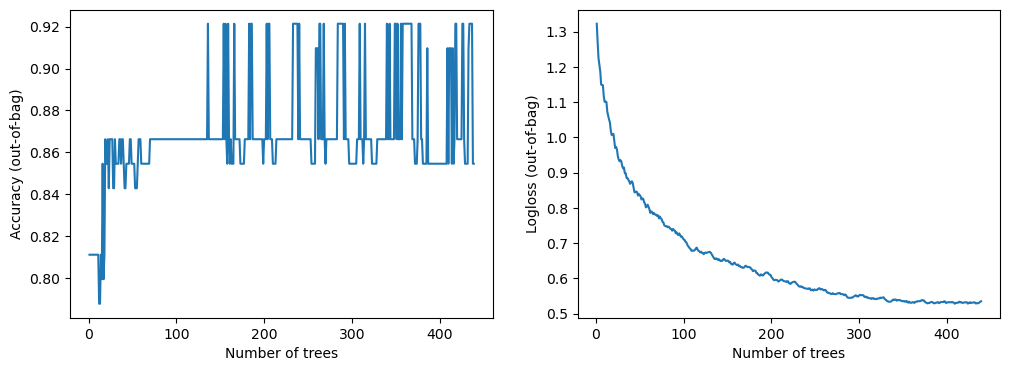


Average accuracy: 0.0000 Average balanced loss: 0.2420


In [25]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

submition_5, model_5,metrics_5 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.GradientBoostedTreesModel,            
    model_kwargs=dict(max_depth=2, num_trees=1000),                                                  
    model_compile_kwargs=dict(metrics=[metrics.accuracy, balanced_logloss_tf]))

# TabPFN

In [60]:
def balanced_logloss_np(y_true: np.array, y_pred: np.array) -> float:
    # y_true is prob that y is equals to 1, we assume that final probs would be P(class_1) = 1 - P(class_0)
    y_pred_1 = y_pred
    y_pred_0 = 1-y_pred

    log_y_pred_1 = np.reshape(np.log(y_pred_1),[-1,1])
    log_y_pred_0 = np.reshape(np.log(y_pred_0),[-1,1])

    y_1 = np.reshape(y_true,[1,-1])
    y_0 = (y_1-1)*(-1)

    logloss_1 = -np.dot(y_1,log_y_pred_1)[0][0]/np.sum(y_1)
    logloss_0 = -np.dot(y_0,log_y_pred_0)[0][0]/np.sum(y_0)

    av_logloss = (logloss_1+logloss_0)/2
    
    return av_logloss

In [67]:
def train_model_tabpfn_one(train: pd.DataFrame, submition: pd.DataFrame, features: list, label = "Class") -> (pd.DataFrame, dict, dict):

    # Create a dataframe of required size with zero values.
    submition_df = pd.DataFrame(data=np.zeros((len(submition.index),1)),index=submition.index)
    train_df_out = pd.DataFrame(data=np.zeros((len(train.index),1)),index=train.index)
    # Create an empty dictionary to store the models trained for each fold.
    models = {}
    metrics = {}

    # Select only feature columns for training.
    train_df = train[features+[label]]

    # Define & Train the model and metrics
    model = TabPFNClassifier(N_ensemble_configurations=64)
    model.fit(train_df[features],train_df[label])

    # Store the model
    models = model

    # Make predictions
    p_train = model.predict_proba(train_df[features])[:,1]
    p_sub = model.predict_proba(submition[features])[:,1]

    # Predict value for validation/Submition data
    submition_df[0] = p_sub.flatten() 
    train_df_out[0] = p_train.flatten() 
    
    # Evaluate and store the metrics in respective dicts
            
    # metrics['accuracy'] = accuracy_score(train_df[label].values, p_train)
    metrics['balanced_logloss'] = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
            
    return train_df_out,submition_df,models,metrics

In [68]:
# TabPFN
train_2, submition_2, model_2,metrics_2 = train_model_tabpfn_one(
    train=train_out,submition=test_out, features=[i for i in features if len(i) > 2])

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


# Submission

In [119]:
# Aggragate Subs
RF_m = pd.Series(metrics_1['balanced_logloss']).mean()
TabPFN_m = pd.Series(metrics_2).mean()

print('RF: metric ', RF_m)
print('TabPFN: metric ', TabPFN_m)

RF_w = 1-(RF_m/(RF_m+TabPFN_m))
TabPFN_w = 1-(TabPFN_m/(RF_m+TabPFN_m))

print('RF weight: ', RF_w)
print('TabPFN weight: ', TabPFN_w)

submition_total = pd.concat([submition_1.mean(axis=1).to_frame(),submition_2], axis=1)
submition_total.columns = ['RF','TabPFN']

submition_total['Ensemble'] = RF_w*submition_total['RF'] + TabPFN_w*submition_total['TabPFN']

# submition_total

submition_total = submition_total[['Ensemble']].copy()

submition_total.columns = ['class_1']

submition_total['class_0'] = 1 - submition_total['class_1']

RF: metric  0.34483136236667633
TabPFN: metric  0.05152794842815339
RF weight:  0.13000312349121568
TabPFN weight:  0.8699968765087843


In [117]:
submition_total.to_csv('/kaggle/working/submission.csv', index=True)

,class_1,class_0
Id,,
00eed32682bb,0.620704,0.379296
010ebe33f668,0.620704,0.379296
02fa521e1838,0.620704,0.379296
040e15f562a2,0.620704,0.379296
046e85c7cc7f,0.620704,0.379296
